In [ ]:
!pip install torchinfo

In [ ]:
import numpy as np
import random

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchinfo import summary

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.1.0+cu118
torchvision version: 0.16.0+cu118


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_all(42)

#Load data (CIFAR-10)

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

# number of samples per batch to load
batch_size = 32
# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# LATER: augment train and validation dataset with random image transformations
#train_transform = transforms.Compose([
#    transforms.RandomHorizontalFlip(), # randomly flip and rotate
#    transforms.RandomRotation(10),
#    transforms.ToTensor(),
#    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#    ])

# split training/test datasets and prepare data loaders
train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:04<00:00, 41534962.54it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

# obtain training indices to be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [ ]:
# prepare data loaders (Dataloader provides an iterable over the specified dataset by combining a dataset with a sampler)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers) #shuffle=True?
valid_loader = DataLoader(dataset=train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers) #shuffle=True?
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, num_workers=num_workers) #shuffle=False?

In [ ]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

#Visualize data

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

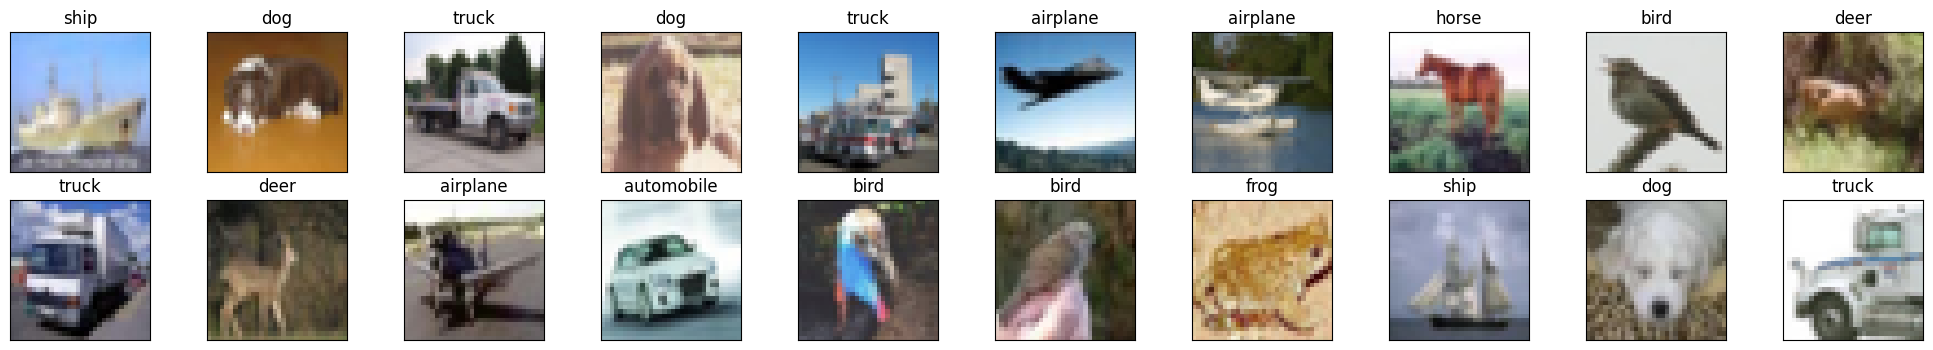

In [ ]:
#  one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

#Train own CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# Print a summary using torchinfo
def print_model_summary(model):
    return summary(model=model,
            input_size=(batch_size, 3, 32, 32), # make sure this is "input_size", not "input_shape"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"]
    )

## Train CNN from scratch without pre-trained models

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = ConvNet()
print(model)


## Train CNN based on pre-trained models

### Simple train and evaluate steps

In [ ]:
num_classes = 10

# Hyperparameters
num_epochs = 20
lr = 0.001

In [ ]:
def train(model, train_loader, loss_fn, optimizer, device, num_epochs=num_epochs):
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        model.train() # set model to train mode
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / total_step}")


def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

### Train pre-trained ResNet50 from scratch (fine-tune)

In [ ]:
# Load pre-trained ResNet50 model
resnet50_no_pretrained_weights = torchvision.models.resnet50(weights=None) # initialize the weights randomly and train the entire network exclusively on the CIFAR dataset

# Modify the last fully connected layer for CIFAR-10
num_ftrs = resnet50_no_pretrained_weights.fc.in_features
resnet50_no_pretrained_weights.fc = nn.Linear(num_ftrs, num_classes)
resnet50_no_pretrained_weights.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
print_model_summary(resnet50_no_pretrained_weights)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 32, 32]      [32, 10]             --                   True
├─Conv2d (conv1)                         [32, 3, 32, 32]      [32, 64, 16, 16]     9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 16, 16]     [32, 64, 16, 16]     128                  True
├─ReLU (relu)                            [32, 64, 16, 16]     [32, 64, 16, 16]     --                   --
├─MaxPool2d (maxpool)                    [32, 64, 16, 16]     [32, 64, 8, 8]       --                   --
├─Sequential (layer1)                    [32, 64, 8, 8]       [32, 256, 8, 8]      --                   True
│    └─Bottleneck (0)                    [32, 64, 8, 8]       [32, 256, 8, 8]      --                   True
│    │    └─Conv2d (conv1)               [32, 64, 8, 8]       [32, 64, 8, 8]       4,096                True
│    │    └─BatchN

In [ ]:
# Specify model
model = resnet50_no_pretrained_weights

# Instantiate the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training the model
train(model, train_loader, loss_fn, optimizer, device, num_epochs)

# Evaluate the model
test_accuracy = evaluate(model, test_loader, device, num_epochs=num_epochs)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/20, Loss: 2.1135651489257814
Epoch 2/20, Loss: 1.9076840148925782
Epoch 3/20, Loss: 1.7208546852588653
Epoch 4/20, Loss: 1.8182479725837708
Epoch 5/20, Loss: 1.6056548762321472
Epoch 6/20, Loss: 1.5177997190475463
Epoch 7/20, Loss: 1.3385143717765808
Epoch 8/20, Loss: 1.2399633080005645
Epoch 9/20, Loss: 1.0848402963161468
Epoch 10/20, Loss: 1.0544283211946488
Epoch 11/20, Loss: 0.9583862205982209
Epoch 12/20, Loss: 0.8312428949832916
Epoch 13/20, Loss: 0.7783307733297348
Epoch 14/20, Loss: 0.6705117095470429
Epoch 15/20, Loss: 0.6157363369941712
Epoch 16/20, Loss: 0.6025980696439743
Epoch 17/20, Loss: 0.5433041753351688
Epoch 18/20, Loss: 0.4340498977482319
Epoch 19/20, Loss: 0.3958944693148136
Epoch 20/20, Loss: 0.3037646227568388
Test Accuracy: 73.61%


### Train pre-trained ResNet50 with pre-trained weights (fine-tune)

In [ ]:
resnet50_fine_tuned_with_pretrained_weights = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT') # Best available weights (currently alias for ResNet50_Weights.IMAGENET1K_V2)

# Modify the last fully connected layer for CIFAR-10
num_ftrs = resnet50_fine_tuned_with_pretrained_weights.fc.in_features
resnet50_fine_tuned_with_pretrained_weights.fc = nn.Linear(num_ftrs, num_classes)
resnet50_fine_tuned_with_pretrained_weights.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Specify model
model = resnet50_fine_tuned_with_pretrained_weights

# Instantiate the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# LATER: Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training the model
train(model, train_loader, loss_fn, optimizer, device, num_epochs) #LATER: add learning rate scheduler?

# Evaluate the model
test_accuracy = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/20, Loss: 1.0241998610973357
Epoch 2/20, Loss: 0.6840945691108704
Epoch 3/20, Loss: 0.556232746732235
Epoch 4/20, Loss: 0.47345882587432864
Epoch 5/20, Loss: 0.40877010990977286
Epoch 6/20, Loss: 0.36967991148531437
Epoch 7/20, Loss: 0.29568293794244527
Epoch 8/20, Loss: 0.2616134574510157
Epoch 9/20, Loss: 0.24768103137537836
Epoch 10/20, Loss: 0.1941163436230272
Epoch 11/20, Loss: 0.19460836493335665
Epoch 12/20, Loss: 0.18077516165822743
Epoch 13/20, Loss: 0.12116573736649007
Epoch 14/20, Loss: 0.12949713799320162
Epoch 15/20, Loss: 0.1111329252676107
Epoch 16/20, Loss: 0.1440060377424583
Epoch 17/20, Loss: 0.08746832880829461
Epoch 18/20, Loss: 0.1455608976876363
Epoch 19/20, Loss: 0.19173994583617895
Epoch 20/20, Loss: 0.055500754858460274
Test Accuracy: 81.84%


### Train pre-trained ResNet50 with pre-trained weights (train classification layer only)

In [ ]:
resnet50_classification_layer_only = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')
for param in resnet50_classification_layer_only.parameters():
  param.requires_grad = False

# Modify the last fully connected layer for CIFAR-10
num_ftrs = resnet50_classification_layer_only.fc.in_features
resnet50_classification_layer_only.fc = nn.Linear(num_ftrs, num_classes)
resnet50_classification_layer_only.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Specify model
model = resnet50_classification_layer_only

# Instantiate the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
# Note: Only parameters of final layer are being optimized as opposed to before.
optimizer = optim.Adam(model.fc.parameters(), lr=lr) # LATER: add e.g. momentum=0.9?
# LATER: Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training the model
train(model, train_loader, loss_fn, optimizer, device, num_epochs) #LATER: add learning rate scheduler?

# Evaluate the model
test_accuracy = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/20, Loss: 1.8551620482444764
Epoch 2/20, Loss: 1.737576229572296
Epoch 3/20, Loss: 1.7235014068603516
Epoch 4/20, Loss: 1.726559974861145
Epoch 5/20, Loss: 1.7300274063110352
Epoch 6/20, Loss: 1.7214349800109863
Epoch 7/20, Loss: 1.7245086373329161
Epoch 8/20, Loss: 1.7324916029930115
Epoch 9/20, Loss: 1.7256877207756043
Epoch 10/20, Loss: 1.7262854884147645
Epoch 11/20, Loss: 1.7337947087287904
Epoch 12/20, Loss: 1.7291060347557068
Epoch 13/20, Loss: 1.7275852579116822
Epoch 14/20, Loss: 1.734032555770874
Epoch 15/20, Loss: 1.7315834421157836
Epoch 16/20, Loss: 1.7281323501586914
Epoch 17/20, Loss: 1.7294791563034058
Epoch 18/20, Loss: 1.7375080949783326
Epoch 19/20, Loss: 1.730202120399475
Epoch 20/20, Loss: 1.7342988404273987
Test Accuracy: 45.66%
